<a href="https://colab.research.google.com/github/DerAndr/classical_ml_course/blob/main/examples/%5BEDA%5D_gender_wage_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Code Snippet
Analyzes a Salary Dataset for Gender Pay Gap Insights

**Author:** Dr. Andrey Holz  
**Contact:** [https://www.linkedin.com/in/andrey-holz](https://www.linkedin.com/in/andrey-holz)

**Dataset Source:** [Mohith Sairam Reddy’s Salary Data on Kaggle](https://www.kaggle.com/datasets/mohithsairamreddy/salary-data)

This notebook performs the following steps:
1. **Data Loading & Inspection**
2. **Data Cleaning & Feature Engineering** (using adaptive quantiles for outlier removal)
3. **Statistical Tests** (Kruskal-Wallis & Pairwise Mann-Whitney U tests with Bonferroni correction)
4. **Visualizations** (Boxplots, Histograms, Scatter, Violin Plots, and Correlation Heatmap)
5. **Additional Analysis: Correlations** (Point-Biserial, Pearson)

# 1. IMPORTS & STYLING

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import statsmodels.stats.multitest as multitest

# Set up colorblind-friendly style and context
sns.set_style("whitegrid")
sns.set_context("talk")

# Define a colorblind-friendly palette
colorblind_palette = sns.color_palette("colorblind")
gender_palette = {
    'Male': "royalblue",     # Blue
    'Female': "darkorange",   # Orange
    'Other': "green"     # Green
}

# 2. LOAD & INSPECT DATA

In [48]:
df = pd.read_csv('/content/Salary_Data.csv')

display(df.head())

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [49]:
print(">> Dataset Info:")
print(df.info(), "\n")
print(">> Shape of DataFrame:", df.shape, "\n")

>> Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB
None 

>> Shape of DataFrame: (6704, 6) 



# 3. DATA CLEANING & FEATURE ENGINEERING


## Keep only rows with 'Gender' in ['Male', 'Female', 'Other']

In [50]:
df = df[df['Gender'].isin(['Male', 'Female', 'Other'])].copy()
df['Gender'] = df['Gender'].str.title()  # Standardize Gender strings

## Adaptive outlier removal for Salary using 1st and 99th percentiles

<Axes: xlabel='Salary', ylabel='Count'>

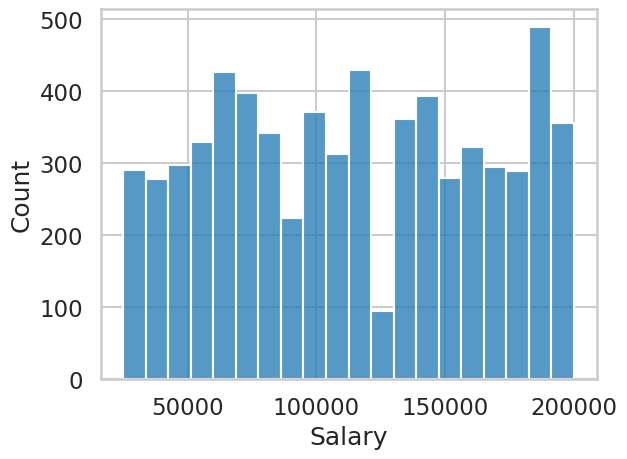

In [66]:
sns.histplot(df['Salary'], bins=20)

In [67]:
lower_salary = df['Salary'].quantile(0.01)
upper_salary = df['Salary'].quantile(0.99)
df = df[(df['Salary'] >= lower_salary) & (df['Salary'] <= upper_salary)]

## Replace infinite values and drop rows with missing values in key columns

In [68]:
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(subset=['Salary', 'Gender', 'Education Level', 'Job Title',
                  'Years of Experience', 'Age'], inplace=True)

## Standardize Education Level to title case

In [69]:
df['Education Level'] = df['Education Level'].str.title()

In [70]:
df['Education Level'].value_counts()

,count
Education Level,
Bs,2995
Ms,1844
Phd,1293
High School,448


In [71]:
education_mapping = {
    "Bachelor'S Degree": "BS",
    "Master'S Degree": "MS",
    "Phd": "PhD",
    "Bachelor'S": "BS",
    "High School": "High School",
    "Master'S": "MS"
}

df['Education Level'] = df['Education Level'].replace(education_mapping)

In [72]:
df['Education Level'].value_counts()

,count
Education Level,
Bs,2995
Ms,1844
PhD,1293
High School,448


## Create an ordinal variable for Education Level using adaptive mapping

In [73]:
education_order = {
    'High School': 1,
    'BS': 2,
    'MS': 3,
    'PhD': 4
}
df['EducationOrdinal'] = df['Education Level'].map(education_order)
df.dropna(subset=['EducationOrdinal'], inplace=True)

# 4. STATISTICAL ANALYSIS (Kruskal-Wallis & Mann-Whitney Tests)

In [74]:
# Conduct a Kruskal-Wallis test across all three groups
groups_list = ['Male', 'Female', 'Other']
group_data = [df.loc[df['Gender'] == g, 'Salary'] for g in groups_list]

H, pvalue = stats.kruskal(*group_data)
print(">> Kruskal-Wallis Test (Male, Female, Other)")
print(f"   H-statistic = {H:.3f}, p-value = {pvalue:.3e}\n")
# A very low p-value (< 0.05) indicates a statistically significant difference.

>> Kruskal-Wallis Test (Male, Female, Other)
   H-statistic = 81.125, p-value = 2.421e-18



In [75]:
# Perform pairwise Mann-Whitney U tests with Bonferroni correction
pairs = [('Male', 'Female'), ('Male', 'Other'), ('Female', 'Other')]
pvals = []
results = []
for (g1, g2) in pairs:
    data1 = df.loc[df['Gender'] == g1, 'Salary']
    data2 = df.loc[df['Gender'] == g2, 'Salary']
    stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    pvals.append(p)
    results.append((g1, g2, stat, p))

reject, pvals_corrected, _, _ = multitest.multipletests(
    pvals, alpha=0.05, method='bonferroni'
)

print(">> Pairwise Mann-Whitney U Tests (Bonferroni Correction):")
for i, (g1, g2, stat, orig_p) in enumerate(results):
    print(f"   {g1} vs {g2}: U = {stat:.3f}, raw p = {orig_p:.3e}, corrected p = {pvals_corrected[i]:.3e}")
print()

>> Pairwise Mann-Whitney U Tests (Bonferroni Correction):
   Male vs Female: U = 457717.500, raw p = 5.171e-19, corrected p = 1.551e-18
   Male vs Other: U = 7924.000, raw p = 4.270e-02, corrected p = 1.281e-01
   Female vs Other: U = 4536.000, raw p = 9.174e-01, corrected p = 1.000e+00



In [76]:
# Conditionally remove 'Other' group if not significantly different from both Male and Female
p_male_other = pvals_corrected[[i for i, pair in enumerate(pairs) if pair == ('Male', 'Other')][0]]
p_female_other = pvals_corrected[[i for i, pair in enumerate(pairs) if pair == ('Female', 'Other')][0]]

removed_other = False  # Flag to record if 'Other' is removed
if (p_male_other > 0.05) and (p_female_other > 0.05):
    print(">> 'Other' group is NOT significantly different from both Male and Female. Excluding 'Other'.\n")
    df_viz = df[df['Gender'].isin(['Male', 'Female'])].copy()
    removed_other = True
else:
    print(">> 'Other' group shows significant differences; keeping all groups.\n")
    df_viz = df.copy()

>> 'Other' group is NOT significantly different from both Male and Female. Excluding 'Other'.



In [98]:
if removed_other:
    print(f"Since the 'Other' group showed no significant difference compared to both Male (p = {p_male_other:.3e}) "
          f"and Female (p = {p_female_other:.3e}), it was excluded from further analysis.")
else:
    print(f"The 'Other' group showed significant differences (Male vs. Other p = {p_male_other:.3e} "
          f"and Female vs. Other p = {p_female_other:.3e}); all groups are included in the analysis.")

Since the 'Other' group showed no significant difference compared to both Male (p = 1.281e-01) and Female (p = 1.000e+00), it was excluded from further analysis.


# 5. VISUALIZATIONS

## 5A. Boxplot: Salary by Gender

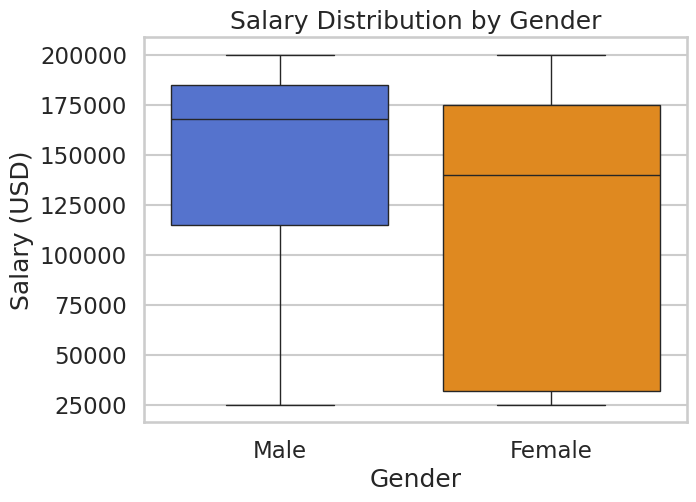

In [100]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Gender', y='Salary', data=df_viz, hue='Gender',
            palette=gender_palette, dodge=False, showfliers=False)
# Remove duplicate legend
plt.legend([],[], frameon=False)
plt.title('Salary Distribution by Gender')
plt.ylabel('Salary (USD)')
plt.show()

## 5B. Histogram + KDE: Salary by Gender

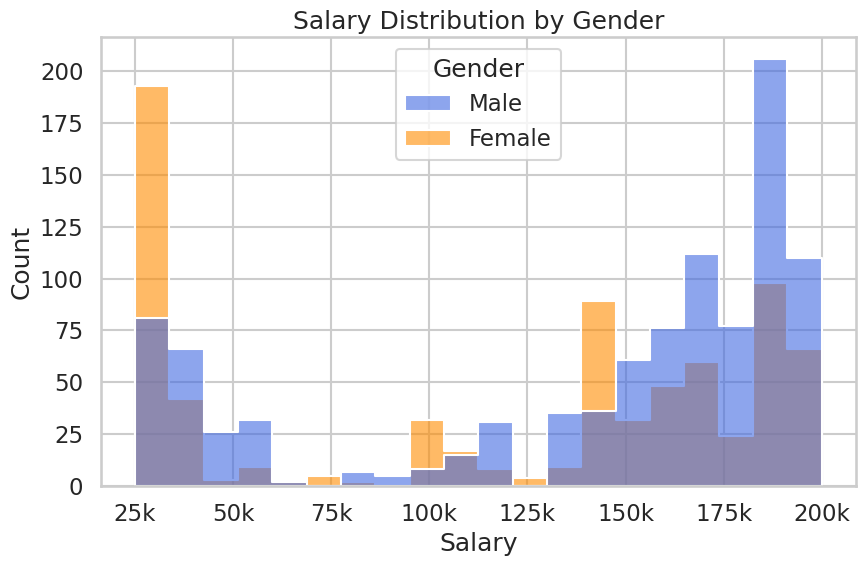

In [108]:
plt.figure(figsize=(9, 6))

sns.histplot(
    x='Salary',
    hue='Gender',
    data=df_viz,
    element='step',
    kde=False,
    palette=gender_palette,
    bins=20,
    alpha=0.6,          # Partial transparency for overlapping bars
    edgecolor='white'   # White edge for clarity
)

plt.title('Salary Distribution by Gender')
plt.xlabel('Salary')

# Get the current Axes object and set a custom formatter
ax = plt.gca()
def k_formatter(x, pos):
    return f"{x/1000:.0f}k"
ax.xaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))

# Safely add legend only if there are handles
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(handles, labels, title='Gender', loc='upper right')

plt.tight_layout()
plt.show()

## 5C. Scatter Plot: Salary vs. Years of Experience by Gender

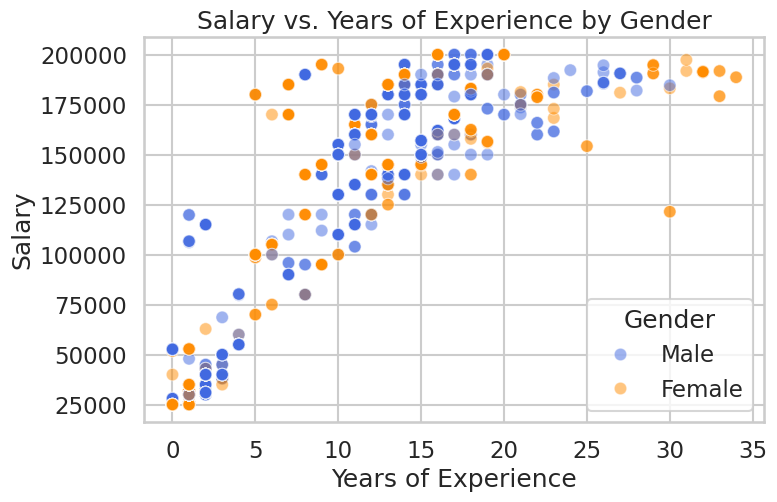

In [79]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Years of Experience', y='Salary', hue='Gender', data=df_viz, palette=gender_palette, alpha=0.5)
plt.title('Salary vs. Years of Experience by Gender')
plt.show()

## 5D. Violin Plot: Salary by Gender and Education Level

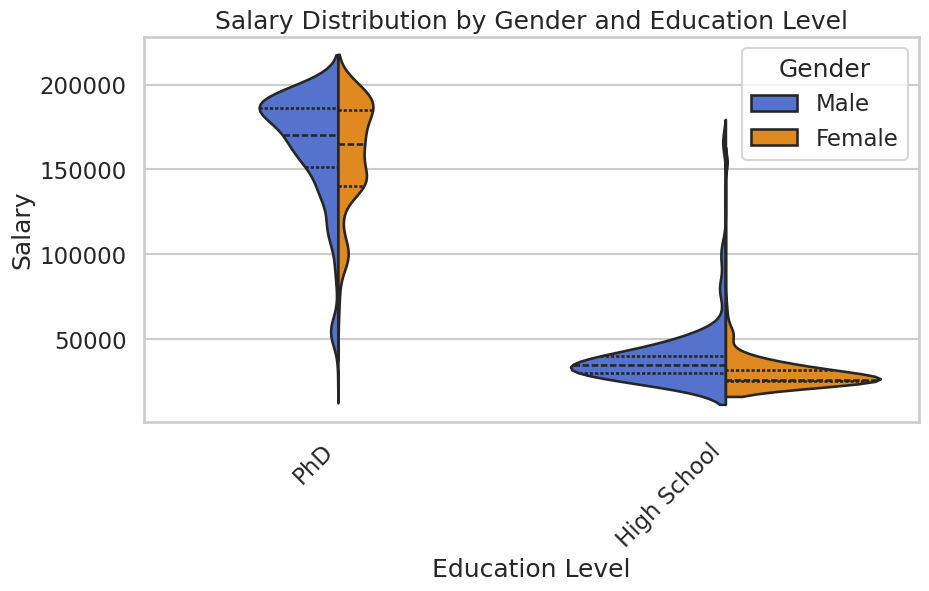

In [80]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='Education Level', y='Salary', hue='Gender', data=df_viz,
               split=True, inner='quartile', palette=gender_palette)
plt.title('Salary Distribution by Gender and Education Level')
plt.xticks(rotation=45, ha='right')
plt.show()

## 5E. Correlation Heatmap: Numerical Features

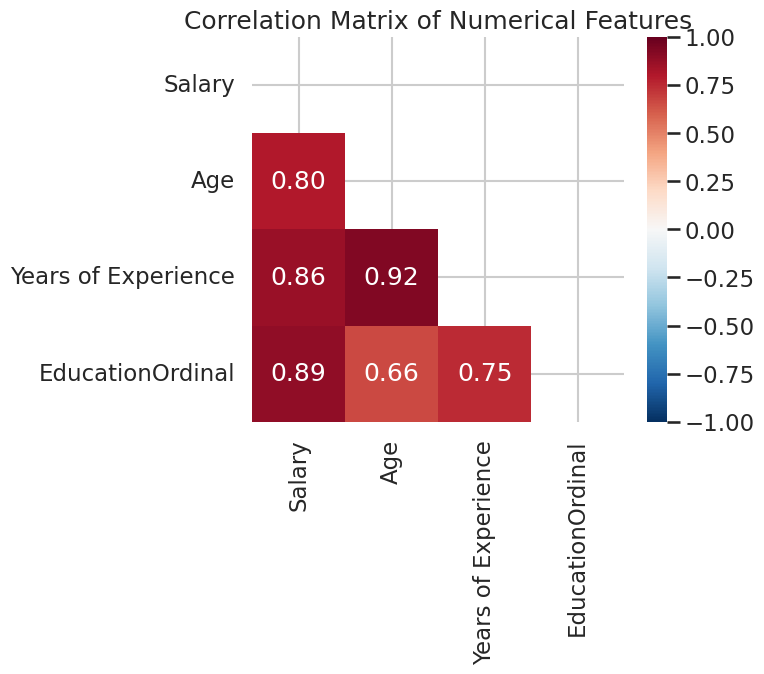

In [82]:
numeric_features = ['Salary', 'Age', 'Years of Experience', 'EducationOrdinal']
corr_matrix = df_viz[numeric_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f",
            vmin=-1, vmax=1, center=0, mask=mask)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## 5F. Single (Split) Violin Plot: Salary Distribution (Male vs. Female)

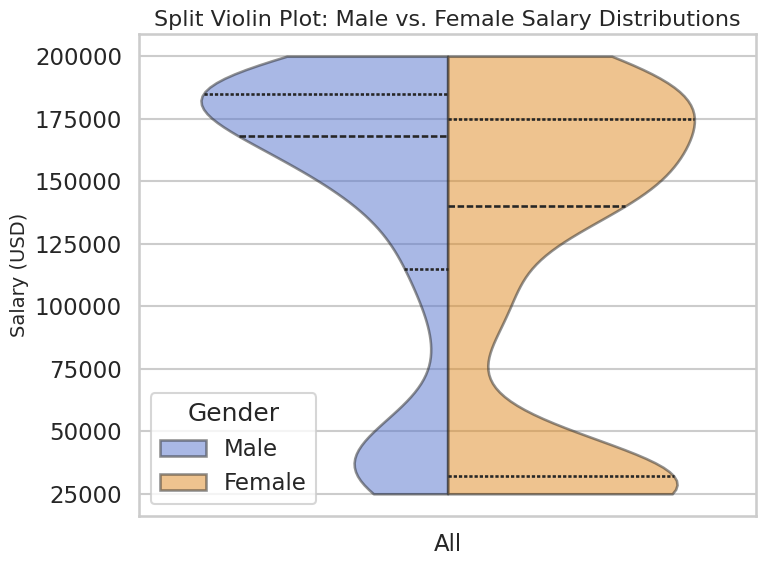

In [85]:
# Only if there are exactly two groups in df_viz.
if len(df_viz['Gender'].unique()) == 2:
    df_viz.loc[:, 'AllCategory'] = 'All'
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='AllCategory', y='Salary', hue='Gender', data=df_viz, split=True,
                   inner='quartile', cut=0, palette=gender_palette, alpha=0.5)
    plt.title('Split Violin Plot: Male vs. Female Salary Distributions', fontsize=16)
    plt.xlabel('')
    plt.ylabel('Salary (USD)', fontsize=14)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()


# 6. DESCRIPTIVE STATS & CORRELATIONS

In [88]:
print(">> Descriptive Statistics by Gender (Final Data):")
print(df_viz.groupby('Gender')['Salary'].describe(), "\n")

>> Descriptive Statistics by Gender (Final Data):
        count           mean           std      min       25%       50%  \
Gender                                                                    
Female  743.0  116233.982503  66454.703623  25000.0   32000.0  140000.0   
Male    986.0  141062.500000  58016.988288  25000.0  115000.0  168000.0   

             75%       max  
Gender                      
Female  174821.0  200000.0  
Male    185000.0  200000.0   



In [94]:
# Point-Biserial Correlation for binary-coded Gender and Salary
df_viz['GenderBinary'] = df_viz['Gender'].map({'Male': 1, 'Female': 0})
corr_pb, p_pb = stats.pointbiserialr(df_viz['GenderBinary'], df_viz['Salary'])
print(f">> Point-Biserial Correlation (Gender vs. Salary): r = {corr_pb:.3f}, p = {p_pb:.3e}")

print(f"The point-biserial correlation between binary-coded Gender and Salary is r = {corr_pb:.3f} "
      f"(p = {p_pb:.3e}), indicating a moderate association.")

>> Point-Biserial Correlation (Gender vs. Salary): r = 0.195, p = 2.598e-16
The point-biserial correlation between binary-coded Gender and Salary is r = 0.195 (p = 2.598e-16), indicating a moderate association.


A point-biserial correlation coefficient of 0.195 indicates a small-to-moderate positive relationship between gender (Male = 1 and Female = 0) and salary. This means that, on average, individuals coded as Male tend to have higher salaries than those coded as Female, but the effect size is relatively modest.

The p-value of 2.598e-16 is extremely low, which means this observed relationship is statistically significant and very unlikely to have occurred by chance.

In [93]:
# Pearson Correlation (EducationOrdinal vs. Salary)
corr_ed, p_ed = stats.pearsonr(df_viz['EducationOrdinal'], df_viz['Salary'])
print(f">> Pearson Correlation (Education vs. Salary): r = {corr_ed:.3f}, p = {p_ed:.3e}\n")

print(f"The Pearson correlation between Education (ordinal) and Salary is r = {corr_ed:.3f} "
      f"(p = {p_ed:.3e}), demonstrating a strong relationship between educational attainment and salary.")

>> Pearson Correlation (Education vs. Salary): r = 0.885, p = 0.000e+00

The Pearson correlation between Education (ordinal) and Salary is r = 0.885 (p = 0.000e+00), demonstrating a strong relationship between educational attainment and salary.


A Pearson correlation coefficient of 0.885 indicates a very strong positive linear relationship between education level (as measured by ordinal variable) and salary. In other words, as education level increases, salary tends to increase significantly. The p-value of 0.000e+00 (effectively 0) means this observed correlation is statistically significant—there is essentially no chance that this strong correlation is due to random variation in data.